In [214]:
from sklearn.datasets import fetch_openml
from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer
from sklearn import tree

import pandas as pd
import numpy as np
import re
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, LabelEncoder
from sklearn.pipeline import Pipeline
import torch.nn as nn
from mpl_toolkits.mplot3d import Axes3D  
import plotly.graph_objects as go
from scipy.stats import gaussian_kde
import matplotlib.patches as mpatches
import matplotlib.dates as mdates


In [215]:
data = pd.read_csv('./Dataset_dumarey/original_csv/Complete.csv')


#### Dataset overview

In [216]:
data.head()


,vin,timestamp,end_time,odo,end_odo,soc,end_soc,event,charge_mode
0,-8.99632E+l8,01/01/2021 20:31,01/01/2021 20:38,4436640625,443946875,564.0,549.0,trip,NaN
1,-8.99632E+ 18,01/01/202120:39,02/01/202115:13,443946875,443946875,549.0,100.0,charge,240
2,-8.99632E+18,02/01/202115:13,02/01/202115:21,443946875,"444,250",100.0,100.0,trip,NaN
3,-8.99632E+18,02/01/202115:21,02/01/202117:46,"444,250","445,7125",100.0,945.0,trip,NaN
4,-8.99632E+18,02/01/202117:46,02/01/202117:53,"445,7125","446,145",945.0,945.0,trip,NaN


In [217]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 192 entries, 0 to 191
Data columns (total 9 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   vin          192 non-null    object 
 1   timestamp    192 non-null    object 
 2   end_time     192 non-null    object 
 3   odo          192 non-null    object 
 4   end_odo      192 non-null    object 
 5   soc          191 non-null    float64
 6   end_soc      191 non-null    float64
 7   event        192 non-null    object 
 8   charge_mode  44 non-null     object 
dtypes: float64(2), object(7)
memory usage: 13.6+ KB


## Data Cleaning


In [218]:
def substitute_comma(ts):
    if pd.isna(ts):
        return ts 
    ts = str(ts).strip()
    ts = ts.replace(",", ".")     
    ts = ts.replace(", ", ".")
    ts = ts.replace(" , ", ".")    
    ts = ts.replace(" ,", ".")       
    ts = ts.replace(". ", ".")    
    ts = ts.replace(" .", ".") 
    ts = ts.replace(" . ", ".")       
    return ts 
def remove_comma(ts):
    if pd.isna(ts):
        return ts 
    ts = str(ts).strip()
    ts = ts.replace(",", "")         
    ts = ts.replace(". ", "")        
    ts = ts.replace(".", "")     
    return ts 


def fix_timestamp_format(ts):
    if pd.isna(ts):
        return ts
    
    ts = str(ts).replace(" ", "")  # rimuove tutti gli spazi
    
    if len(ts) >= 15:  # es. 27/04/202121:27
        return ts[:10] + ' ' + ts[10:]
    else:
        return ts
def fix_soc (ts):
    if ts > 100.0:
        return ts / 10
    else:
        return ts
def fix_odo(ts):
    if pd.isna(ts):
        return ts
    try:
        ts_str = str(int(ts))
        if len(ts_str) <= 4:
            return int(ts_str)  # lascia invariato
        return float(ts_str[:4] + '.' + ts_str[4:])
    except:
        return ts
def fix_vin (ts):
    if pd.isna(ts):
        return ts 
    ts = str(ts)
    if ts.startswith('-8.9'):
        return '1.0'
    elif ts.startswith('-2.4'):
        return '2.0'
    elif ts.startswith('·2.4'):
        return '2.0'
    else:
        return ts


#### Fixing marks

In [219]:
data['odo'] = data['odo'].apply(remove_comma)
data['end_odo'] = data['end_odo'].apply(remove_comma)
data['soc'] = data['soc'].apply(substitute_comma)
data['end_soc'] = data['end_soc'].apply(substitute_comma)

In [220]:
data.head()

,vin,timestamp,end_time,odo,end_odo,soc,end_soc,event,charge_mode
0,-8.99632E+l8,01/01/2021 20:31,01/01/2021 20:38,4436640625,443946875,564.0,549.0,trip,NaN
1,-8.99632E+ 18,01/01/202120:39,02/01/202115:13,443946875,443946875,549.0,100.0,charge,240
2,-8.99632E+18,02/01/202115:13,02/01/202115:21,443946875,444250,100.0,100.0,trip,NaN
3,-8.99632E+18,02/01/202115:21,02/01/202117:46,444250,4457125,100.0,945.0,trip,NaN
4,-8.99632E+18,02/01/202117:46,02/01/202117:53,4457125,446145,945.0,945.0,trip,NaN


#### From object to float64


In [221]:
cols_to_float = ['odo', 'end_odo', 'soc', 'end_soc']
for col in cols_to_float:
    data[col] = pd.to_numeric(data[col], errors='coerce')

#### Fixing timestamp format

In [222]:
data['timestamp'] = data['timestamp'].apply(fix_timestamp_format)
data['end_time'] = data['end_time'].apply(fix_timestamp_format) 
data['timestamp'] = pd.to_datetime(data['timestamp'], errors='coerce', dayfirst=True)
data['end_time'] = pd.to_datetime(data['end_time'], errors='coerce', dayfirst=True)

#### Value correction

In [223]:
data['soc'] = data['soc'].apply(fix_soc)
data['end_soc'] = data['end_soc'].apply(fix_soc)
data['odo'] = data['odo'].apply(fix_odo)
data['end_odo'] = data['end_odo'].apply(fix_odo)


#### Clean and convert (vin, event, charge_mode)

In [224]:
data.head()

,vin,timestamp,end_time,odo,end_odo,soc,end_soc,event,charge_mode
0,-8.99632E+l8,2021-01-01 20:31:00,2021-01-01 20:38:00,4436.640625,4439.46875,56.4,54.9,trip,NaN
1,-8.99632E+ 18,2021-01-01 20:39:00,2021-01-02 15:13:00,4439.468750,4439.46875,54.9,100.0,charge,240
2,-8.99632E+18,2021-01-02 15:13:00,2021-01-02 15:21:00,4439.468750,4442.50000,100.0,100.0,trip,NaN
3,-8.99632E+18,2021-01-02 15:21:00,2021-01-02 17:46:00,4442.500000,4457.12500,100.0,94.5,trip,NaN
4,-8.99632E+18,2021-01-02 17:46:00,2021-01-02 17:53:00,4457.125000,4461.45000,94.5,94.5,trip,NaN


In [225]:
cols_to_convert = ['event', 'charge_mode']
for col in cols_to_convert:
    data[col] = data[col].astype('category')
data['charge_mode'] = data['charge_mode'].cat.add_categories('0').fillna('0')
data['vin'] = data['vin'].apply(fix_vin)

data['vin'] = data['vin'].astype('float64')

### Inspect dataset structure

In [226]:
print(f"Element of the dataset: {len(data)}")
print(f"Columns of the dataset: {data.columns.to_list()}")


Element of the dataset: 192
Columns of the dataset: ['vin', 'timestamp', 'end_time', 'odo', 'end_odo', 'soc', 'end_soc', 'event', 'charge_mode']


In [227]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 192 entries, 0 to 191
Data columns (total 9 columns):
 #   Column       Non-Null Count  Dtype         
---  ------       --------------  -----         
 0   vin          192 non-null    float64       
 1   timestamp    192 non-null    datetime64[ns]
 2   end_time     192 non-null    datetime64[ns]
 3   odo          192 non-null    float64       
 4   end_odo      192 non-null    float64       
 5   soc          191 non-null    float64       
 6   end_soc      191 non-null    float64       
 7   event        192 non-null    category      
 8   charge_mode  192 non-null    category      
dtypes: category(2), datetime64[ns](2), float64(5)
memory usage: 11.5 KB


In [228]:
data.head()

,vin,timestamp,end_time,odo,end_odo,soc,end_soc,event,charge_mode
0,1.0,2021-01-01 20:31:00,2021-01-01 20:38:00,4436.640625,4439.46875,56.4,54.9,trip,0
1,1.0,2021-01-01 20:39:00,2021-01-02 15:13:00,4439.468750,4439.46875,54.9,100.0,charge,240
2,1.0,2021-01-02 15:13:00,2021-01-02 15:21:00,4439.468750,4442.50000,100.0,100.0,trip,0
3,1.0,2021-01-02 15:21:00,2021-01-02 17:46:00,4442.500000,4457.12500,100.0,94.5,trip,0
4,1.0,2021-01-02 17:46:00,2021-01-02 17:53:00,4457.125000,4461.45000,94.5,94.5,trip,0


In [229]:
data.head()

,vin,timestamp,end_time,odo,end_odo,soc,end_soc,event,charge_mode
0,1.0,2021-01-01 20:31:00,2021-01-01 20:38:00,4436.640625,4439.46875,56.4,54.9,trip,0
1,1.0,2021-01-01 20:39:00,2021-01-02 15:13:00,4439.468750,4439.46875,54.9,100.0,charge,240
2,1.0,2021-01-02 15:13:00,2021-01-02 15:21:00,4439.468750,4442.50000,100.0,100.0,trip,0
3,1.0,2021-01-02 15:21:00,2021-01-02 17:46:00,4442.500000,4457.12500,100.0,94.5,trip,0
4,1.0,2021-01-02 17:46:00,2021-01-02 17:53:00,4457.125000,4461.45000,94.5,94.5,trip,0


# Dataset statistics: missing values, duplicates and irrelevant rows

In [230]:
nan_count = data.isna().sum()
print("| Features | NaN-counter |")
print(nan_count)
print("|----------|-------------|")

# Separa
print("\n🔍 Rows with missing values:\n")

# Filtra le righe con almeno un NaN
rows_with_nan = data[data.isna().any(axis=1)]


rows_with_nan.head(len(rows_with_nan))


| Features | NaN-counter |
vin            0
timestamp      0
end_time       0
odo            0
end_odo        0
soc            1
end_soc        1
event          0
charge_mode    0
dtype: int64
|----------|-------------|

🔍 Rows with missing values:



,vin,timestamp,end_time,odo,end_odo,soc,end_soc,event,charge_mode
15,1.0,2021-01-04 17:54:00,2021-01-04 17:54:00,4665.203125,4665.203125,45.0,NaN,charge,240
16,1.0,2021-01-04 17:54:00,2021-01-04 18:16:00,4665.203125,4667.953125,NaN,44.3,trip,0


In [231]:
#number of rows where event = charge and charge_mode = 0
charge_mode_0_count = data[(data['event'] == 'charge') & (data['charge_mode'] == '0')]
print(f"Number of rows where event = 'charge' and charge_mode = '0': {charge_mode_0_count.shape[0]}")
print("\n The rows are:\n")
charge_mode_0_count.head(len(charge_mode_0_count))

Number of rows where event = 'charge' and charge_mode = '0': 1

 The rows are:



,vin,timestamp,end_time,odo,end_odo,soc,end_soc,event,charge_mode
86,2.0,2021-05-04 15:45:00,2021-05-04 17:46:00,2734.28125,2734.28125,10.5,12.5,charge,0


In [232]:
data = data.drop(charge_mode_0_count.index)

In [233]:
duplicates = data.duplicated()
print(f"Duplicates: {duplicates.sum()}")
data = data[~duplicates]

Duplicates: 0


In [234]:
print(f"Element of the dataset: {len(data)}")

Element of the dataset: 191


## Strategies for filling null values

In [235]:
#fill missing values in data with the mean of the column
imputer = SimpleImputer(strategy='mean')
def impute_missing_values(data):
    for col in data.columns:
        if data[col].dtype in ['float64', 'int64']:
            data[col] = imputer.fit_transform(data[[col]])
    return data


In [236]:
# Removing rows with NaN values for any column
def remove_nan_rows(data):
    data = data.dropna()
    return data


In [237]:
#data = impute_missing_values(data)
data = remove_nan_rows(data)

In [238]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 189 entries, 0 to 191
Data columns (total 9 columns):
 #   Column       Non-Null Count  Dtype         
---  ------       --------------  -----         
 0   vin          189 non-null    float64       
 1   timestamp    189 non-null    datetime64[ns]
 2   end_time     189 non-null    datetime64[ns]
 3   odo          189 non-null    float64       
 4   end_odo      189 non-null    float64       
 5   soc          189 non-null    float64       
 6   end_soc      189 non-null    float64       
 7   event        189 non-null    category      
 8   charge_mode  189 non-null    category      
dtypes: category(2), datetime64[ns](2), float64(5)
memory usage: 12.7 KB


## Cleaning data from useless rows (trip, charge)

In [239]:
useless_rows_trip = data[(data['event'] == 'trip') & (data['soc'] == data['end_soc']) & (data['end_odo'] == data['odo'])& (data['timestamp'] == data['end_time'])]
print(f"Number of useless rows: {useless_rows_trip.shape[0]}")
useless_rows_trip.head(len(useless_rows_trip))

Number of useless rows: 5


,vin,timestamp,end_time,odo,end_odo,soc,end_soc,event,charge_mode
22,1.0,2021-01-05 11:59:00,2021-01-05 11:59:00,4868.421875,4868.421875,16.0,16.0,trip,0
27,1.0,2021-01-05 18:54:00,2021-01-05 18:54:00,4880.484375,4880.484375,59.6,59.6,trip,0
37,2.0,2021-04-27 21:29:00,2021-04-27 21:29:00,2142.859375,2142.859375,60.3,60.3,trip,0
169,2.0,2021-05-13 04:11:00,2021-05-13 04:11:00,4004.531250,4004.531250,6.2,6.2,trip,0
178,2.0,2021-05-13 23:09:00,2021-05-13 23:09:00,4137.046875,4137.046875,18.8,18.8,trip,0


In [240]:
useless_rows_charge = data[(data['event'] == 'charge') & (data['soc'] == data['end_soc'])& (data['timestamp'] == data['end_time'])]
print(f"Number of useless rows: {useless_rows_charge.shape[0]}")
useless_rows_charge.head(len(useless_rows_charge))

Number of useless rows: 0


,vin,timestamp,end_time,odo,end_odo,soc,end_soc,event,charge_mode


In [241]:
data = data.drop(useless_rows_trip.index)
data = data.drop(useless_rows_charge.index)


# Added Duration column (end_time - timestamp) in minute

In [242]:
# add a column duration
data['duration'] = (data['end_time'] - data['timestamp']).dt.total_seconds()/60

In [243]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 184 entries, 0 to 191
Data columns (total 10 columns):
 #   Column       Non-Null Count  Dtype         
---  ------       --------------  -----         
 0   vin          184 non-null    float64       
 1   timestamp    184 non-null    datetime64[ns]
 2   end_time     184 non-null    datetime64[ns]
 3   odo          184 non-null    float64       
 4   end_odo      184 non-null    float64       
 5   soc          184 non-null    float64       
 6   end_soc      184 non-null    float64       
 7   event        184 non-null    category      
 8   charge_mode  184 non-null    category      
 9   duration     184 non-null    float64       
dtypes: category(2), datetime64[ns](2), float64(6)
memory usage: 13.8 KB


# Summary statistics: odo and soc

In [244]:
# statistics of the dataset for odo, end_odo, soc, end_soc
print("Statistics of the dataset:")
data[['odo', 'end_odo', 'soc', 'end_soc']].describe().T

Statistics of the dataset:


,count,mean,std,min,25%,50%,75%,max
odo,184.0,3320.027154,832.393813,2096.265625,2662.867188,3001.125000,4035.515625,4973.250000
end_odo,184.0,3336.458879,837.416229,2106.125000,2667.121094,3003.226562,4037.542969,4974.078125
soc,184.0,44.051630,24.233775,3.500000,24.600000,41.500000,59.300000,100.000000
end_soc,184.0,43.734239,24.423819,3.500000,24.300000,40.350000,59.300000,100.000000


# Event Analysis and Statistical Characterization

## Anomalies in Charge and Trip events

In [245]:
useless_rows_trip = data[(data['event'] == 'trip') & (data['soc'] == data['end_soc']) & (data['end_odo'] == data['odo'])& (data['timestamp'] != data['end_time'])]
print(f"Number of useless rows: {useless_rows_trip.shape[0]}")
useless_rows_trip.head(len(useless_rows_trip))

Number of useless rows: 1


,vin,timestamp,end_time,odo,end_odo,soc,end_soc,event,charge_mode,duration
12,1.0,2021-01-03 21:56:00,2021-01-03 22:00:00,4658.234375,4658.234375,46.6,46.6,trip,0,4.0


0.0


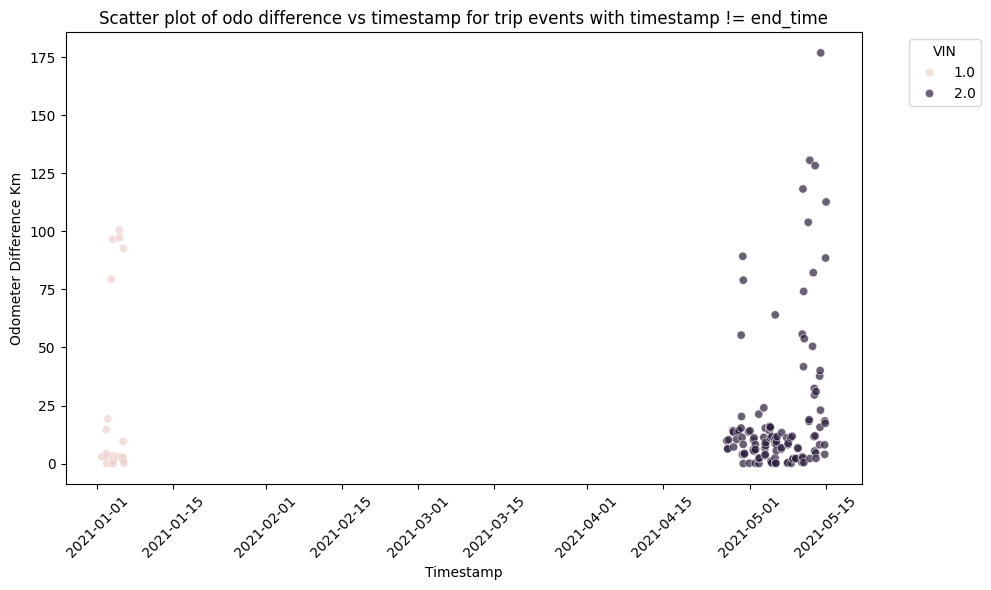

In [246]:
# filtro i dati
filtered_data = data[(data['event'] == 'trip') & (data['timestamp'] != data['end_time'])].copy()

# calcolo la differenza tra end_odo e odo
filtered_data['odo_diff'] = filtered_data['end_odo'] - filtered_data['odo']
print(filtered_data['odo_diff'].min())
# plot
plt.figure(figsize=(10, 6))
sns.scatterplot(
    data=filtered_data, 
    x='timestamp', 
    y='odo_diff', 
    hue='vin', 
    alpha=0.7
)
plt.title('Scatter plot of odo difference vs timestamp for trip events with timestamp != end_time')
plt.xlabel('Timestamp')
plt.ylabel('Odometer Difference Km')
plt.xticks(rotation=45)
plt.legend(title='VIN', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

In [247]:
useless_rows_charge = data[(data['event'] == 'charge') & (data['soc'] == data['end_soc'])& (data['timestamp'] != data['end_time'])]
print(f"Number of useless rows: {useless_rows_charge.shape[0]}")
useless_rows_charge.head(len(useless_rows_charge))

Number of useless rows: 3


,vin,timestamp,end_time,odo,end_odo,soc,end_soc,event,charge_mode,duration
21,1.0,2021-01-05 11:57:00,2021-01-05 11:59:00,4868.421875,4868.421875,16.0,16.0,charge,240,2.0
136,2.0,2021-05-10 17:54:00,2021-05-10 18:29:00,3083.781250,3083.781250,76.0,76.0,charge,120,35.0
162,2.0,2021-05-13 00:13:00,2021-05-13 00:21:00,3869.421875,3869.421875,30.1,30.1,charge,120,8.0


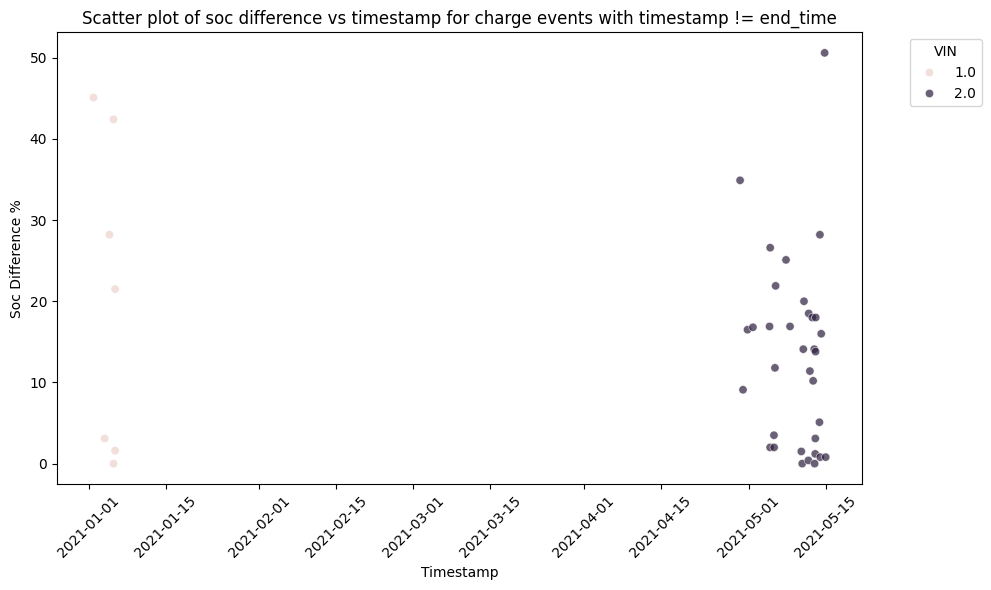

In [248]:
# filtro i dati
filtered_data = data[(data['event'] == 'charge') & (data['timestamp'] != data['end_time'])].copy()

# calcolo la differenza tra end_odo e odo
filtered_data['soc_diff'] = filtered_data['end_soc'] - filtered_data['soc']

# plot
plt.figure(figsize=(10, 6))
sns.scatterplot(
    data=filtered_data, 
    x='timestamp', 
    y='soc_diff', 
    hue='vin', 
    alpha=0.7
)
plt.title('Scatter plot of soc difference vs timestamp for charge events with timestamp != end_time')
plt.xlabel('Timestamp')
plt.ylabel('Soc Difference %')
plt.xticks(rotation=45)
plt.legend(title='VIN', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

In [249]:
anomalous_rows_trip = data[(data['event'] == 'trip') & (data['end_soc'] > data['soc']) ]
print(f"Number of anamalous rows: {anomalous_rows_trip.shape[0]}")
anomalous_rows_trip.head(len(anomalous_rows_trip ))

Number of anamalous rows: 3


,vin,timestamp,end_time,odo,end_odo,soc,end_soc,event,charge_mode,duration
24,1.0,2021-01-05 17:05:00,2021-01-05 17:12:00,4868.421875,4870.953125,58.4,58.8,trip,0,7.0
73,2.0,2021-05-02 16:53:00,2021-05-02 16:57:00,2609.656250,2611.796875,33.3,33.7,trip,0,4.0
93,2.0,2021-05-04 22:08:00,2021-05-04 22:12:00,2777.484375,2778.328125,24.3,24.7,trip,0,4.0


In [250]:
anomalous_rows_trip = data[(data['event'] == 'trip') & (data['end_odo'] < data['odo']) ]
print(f"Number of anamalous rows: {anomalous_rows_trip.shape[0]}")
anomalous_rows_trip.head(len(anomalous_rows_trip ))

Number of anamalous rows: 0


,vin,timestamp,end_time,odo,end_odo,soc,end_soc,event,charge_mode,duration


In [251]:
anomalows_rows_charge = data[(data['event'] == 'charge') & (data['end_soc'] < data['soc']) ]
print(f"Number of anamalous rows: {anomalows_rows_charge.shape[0]}")
anomalows_rows_charge.head(len(anomalows_rows_charge))

Number of anamalous rows: 0


,vin,timestamp,end_time,odo,end_odo,soc,end_soc,event,charge_mode,duration


## Discharge

In [252]:

trip_data = data[data['event'] == 'trip'].copy().reset_index(drop=True)
trip_data['km_driven'] = trip_data['end_odo'] - trip_data['odo']
trip_data['discharge'] = trip_data['soc'] - trip_data['end_soc']
print("📊 Statistics on driven km:\n", trip_data['km_driven'].describe())
print("\n🔋 Statistics on discharge:\n", trip_data['discharge'].describe())
print(trip_data['discharge'])

📊 Statistics on driven km:
 count    143.000000
mean      21.142810
std       32.562403
min        0.000000
25%        2.890625
50%        9.062500
75%       16.695312
max      176.796875
Name: km_driven, dtype: float64

🔋 Statistics on discharge:
 count    143.000000
mean       4.546154
std        7.835238
min       -0.400000
25%        0.400000
50%        1.600000
75%        3.550000
max       43.100000
Name: discharge, dtype: float64
0       1.5
1       0.0
2       5.5
3       0.0
4       0.0
       ... 
138     0.0
139     3.2
140     3.9
141    18.0
142    22.4
Name: discharge, Length: 143, dtype: float64


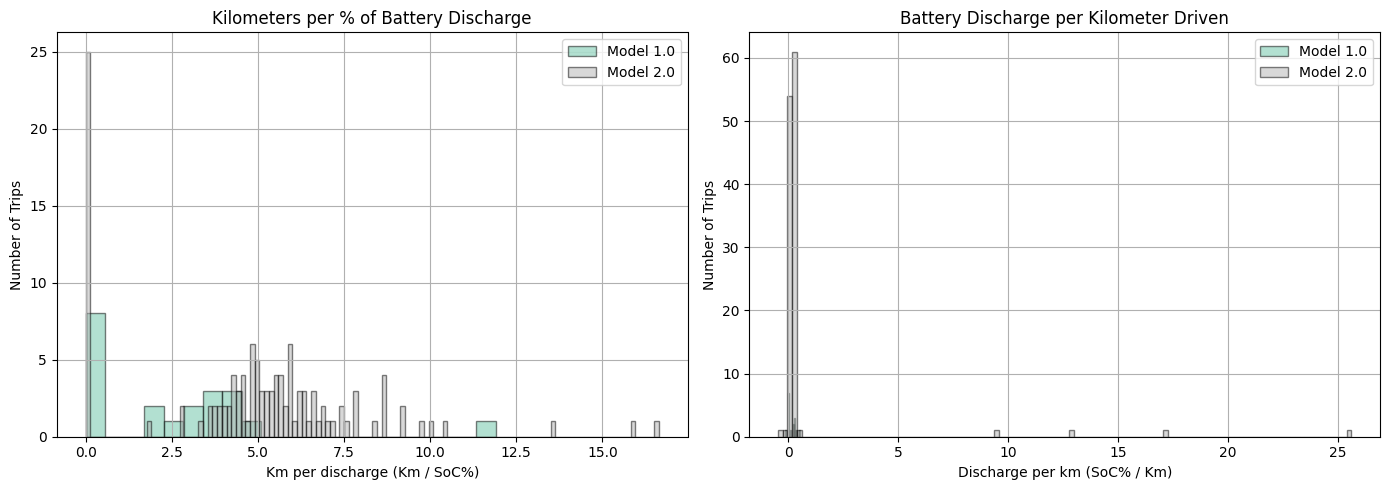

In [253]:

trip_data['km_per_perc_of_battery'] = trip_data.apply(
    lambda row: row['km_driven'] / row['discharge'] if row['discharge'] > 0 else 0,
    axis=1
)

trip_data['discharge_per_km'] = trip_data.apply(
    lambda row: row['discharge'] / row['km_driven'] if row['km_driven'] > 0 else 0,
    axis=1
)

# Setup
models = trip_data['vin'].dropna().unique()
colors = plt.get_cmap('Set2', len(models))

fig, axes = plt.subplots(1, 2, figsize=(14, 5))


for i, model in enumerate(models):
    subset = trip_data[trip_data['vin'] == model]
    axes[0].hist(
        subset['km_per_perc_of_battery'],
        bins=len(subset),
        alpha=0.5,
        color=colors(i),
        label=f'Model {model}',
        edgecolor='black'
    )

axes[0].set_title('Kilometers per % of Battery Discharge')
axes[0].set_xlabel('Km per discharge (Km / SoC%)')
axes[0].set_ylabel('Number of Trips')
axes[0].grid(True)
axes[0].legend()

for i, model in enumerate(models):
    subset = trip_data[trip_data['vin'] == model]
    axes[1].hist(
        subset['discharge_per_km'],
        bins=len(subset),
        alpha=0.5,
        color=colors(i),
        label=f'Model {model}',
        edgecolor='black'
    )

axes[1].set_title('Battery Discharge per Kilometer Driven')
axes[1].set_xlabel('Discharge per km (SoC% / Km)')
axes[1].set_ylabel('Number of Trips')
axes[1].grid(True)
axes[1].legend()

plt.tight_layout()
plt.show()

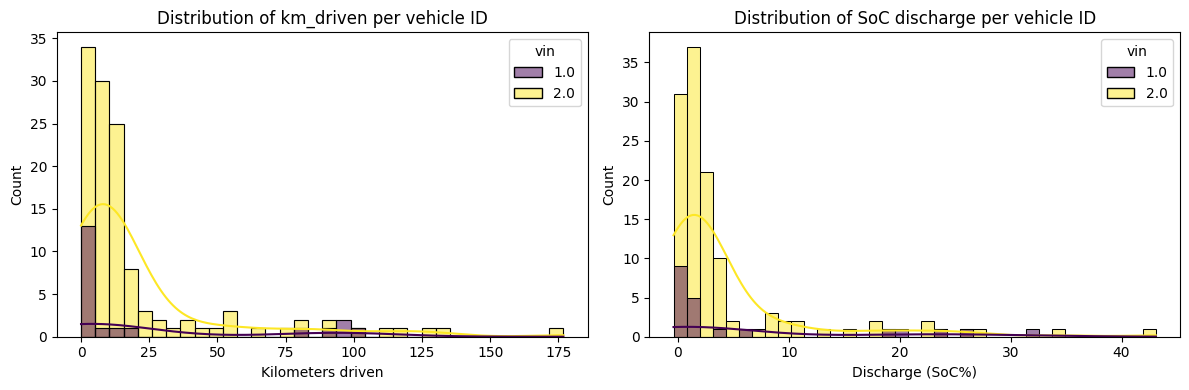

In [254]:
fig, axes = plt.subplots(1, 2, figsize=(12, 4))

sns.histplot(data=trip_data, x='km_driven', kde=True, hue='vin', palette='viridis', ax=axes[0])
axes[0].set_title('Distribution of km_driven per vehicle ID')
axes[0].set_xlabel('Kilometers driven')

sns.histplot(data=trip_data, x='discharge', kde=True, hue='vin', palette='viridis', ax=axes[1])
axes[1].set_title('Distribution of SoC discharge per vehicle ID')
axes[1].set_xlabel('Discharge (SoC%)')

plt.tight_layout()
plt.show()

In [255]:
import numpy as np
import plotly.graph_objects as go

vehicles = trip_data['vin'].unique()
colors = ['Blues', 'Reds', 'Greens', 'Purples', 'Oranges', 'Viridis'] 

fig = go.Figure()

x = trip_data['km_driven'].values
y = trip_data['discharge'].values
xedges = np.linspace(x.min(), x.max(), 31)
yedges = np.linspace(y.min(), y.max(), 31)
xcenters = 0.5 * (xedges[:-1] + xedges[1:])
ycenters = 0.5 * (yedges[:-1] + yedges[1:])
X, Y = np.meshgrid(xcenters, ycenters, indexing="ij")

for i, vin in enumerate(vehicles):
    subset = trip_data[trip_data['vin'] == vin]
    hist, _, _ = np.histogram2d(
        subset['km_driven'], subset['discharge'],
        bins=[xedges, yedges],
        density=True
    )
    
    # Surface plot
    fig.add_trace(go.Surface(
        x=X,
        y=Y,
        z=hist,
        colorscale=colors[i % len(colors)],
        showscale=False,
        name=f'Vehicle {vin}',
        opacity=0.8,
        hoverinfo="skip", 
        legendgroup=f'{vin}',  # raggruppa
        showlegend=True  
    ))

    

fig.update_layout(
    title='3D Histogram Surface of km_driven and discharge by Vehicle',
    scene=dict(
        xaxis_title='Kilometers driven',
        yaxis_title='Discharge (SoC%)',
        zaxis_title='Density'
    ),
    margin=dict(l=0, r=0, b=0, t=40),
    legend=dict(title="Vehicles")
)

fig.show()

/Users/gabriele/Desktop/Magistrale/Tesi/env/lib/python3.13/site-packages/mpl_toolkits/mplot3d/art3d.py:1403: RuntimeWarning:

divide by zero encountered in matmul

/Users/gabriele/Desktop/Magistrale/Tesi/env/lib/python3.13/site-packages/mpl_toolkits/mplot3d/art3d.py:1403: RuntimeWarning:

overflow encountered in matmul



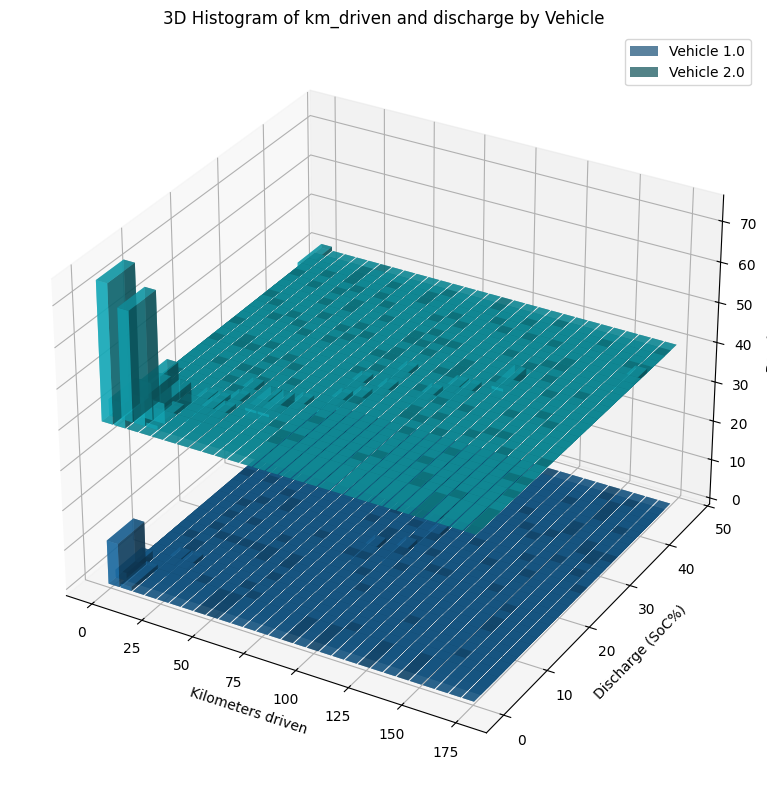

In [256]:
from matplotlib import pyplot


vehicles = trip_data['vin'].unique()
colors = pyplot.get_cmap('tab10', len(vehicles))  

fig = plt.figure(figsize=(12, 8))
ax = fig.add_subplot(111, projection='3d')


x = trip_data['km_driven']
y = trip_data['discharge']
xedges = np.linspace(x.min(), x.max(), 30)
yedges = np.linspace(y.min(), y.max(), 30)

dx = dy = (xedges[1] - xedges[0]) * 0.9

for i, vin in enumerate(vehicles):
    subset = trip_data[trip_data['vin'] == vin]
    hist, xedges_sub, yedges_sub = np.histogram2d(subset['km_driven'], subset['discharge'], bins=[xedges, yedges], density=False)

    xpos, ypos = np.meshgrid(xedges[:-1], yedges[:-1], indexing="ij")
    xpos = xpos.ravel()
    ypos = ypos.ravel()
    zpos = np.zeros_like(xpos)
    dz = hist.ravel()


    z_offset = i * dz.max() * 1.2
    zpos = zpos + z_offset

    ax.bar3d(xpos, ypos, zpos, dx, dy, dz, color=colors(i), alpha=0.7, label=f'Vehicle {vin}', shade=True)

ax.set_xlabel('Kilometers driven')
ax.set_ylabel('Discharge (SoC%)')
ax.set_zlabel('Density')
ax.set_title('3D Histogram of km_driven and discharge by Vehicle')
ax.legend()

plt.tight_layout()
plt.show()

In [257]:
vehicles = trip_data['vin'].unique()
colors = ['Viridis', 'Cividis', 'Plasma', 'Inferno', 'Magma', 'Turbo']  

fig = go.Figure()


x = trip_data['km_driven'].values
y = trip_data['discharge'].values
xgrid = np.linspace(x.min(), x.max(), 100)
ygrid = np.linspace(y.min(), y.max(), 100)
X, Y = np.meshgrid(xgrid, ygrid)
positions = np.vstack([X.ravel(), Y.ravel()])

for i, vin in enumerate(vehicles):
    subset = trip_data[trip_data['vin'] == vin]
    xy_subset = np.vstack([subset['km_driven'].values, subset['discharge'].values])
    kde = gaussian_kde(xy_subset)
    Z = np.reshape(kde(positions).T, X.shape)
    
    fig.add_trace(go.Surface(
        x=X,
        y=Y,
        z=Z,
        colorscale=colors[i % len(colors)],
        name=f'Vehicle {vin}',
        showscale=False,
        opacity=0.8,
        showlegend=True  
    ))

fig.update_layout(
    title='3D KDE Surface of km_driven and discharge by Vehicle',
    scene=dict(
        xaxis_title='Kilometers driven',
        yaxis_title='Discharge (SoC%)',
        zaxis_title='Density'
    ),
    margin=dict(l=0, r=0, b=0, t=40)
)

fig.show()

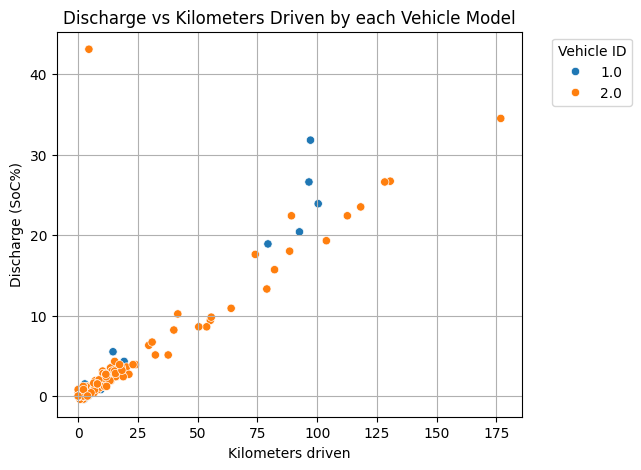

In [258]:
plt.figure(figsize=(6, 5))
sns.scatterplot(data=trip_data, x='km_driven', y='discharge',hue = 'vin', palette = 'tab10')
plt.title('Discharge vs Kilometers Driven by each Vehicle Model')
plt.legend(title='Vehicle ID', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.xlabel('Kilometers driven')
plt.ylabel('Discharge (SoC%)')
plt.grid(True)
plt.show()

#### Visualize battery discharge across driven distance for each trip

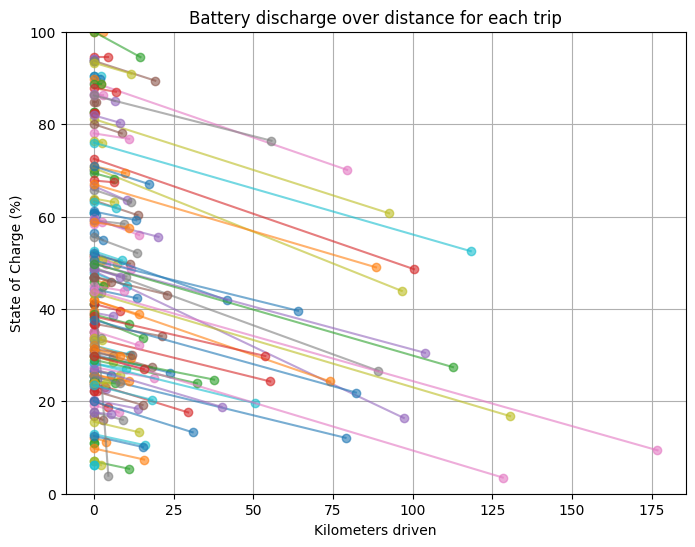

In [259]:
plt.figure(figsize=(8, 6))

for _, row in trip_data.iterrows():
    x_vals = [0, row['km_driven']]
    y_vals = [row['soc'], row['end_soc']]
    plt.plot(x_vals, y_vals, marker='o', alpha=0.6)


plt.xlabel('Kilometers driven')
plt.ylabel('State of Charge (%)')
plt.title('Battery discharge over distance for each trip')
plt.ylim(0, 100)
plt.grid(True)
plt.show()

## Charge

In [260]:
charge_data = data[data['event'] == 'charge'].copy().reset_index(drop=True)
charge_data['diff_battery'] = charge_data['end_soc'] - charge_data['soc']
print("🔋 Statistics on charge km:\n", charge_data['diff_battery'].describe())


🔋 Statistics on charge km:
 count    41.000000
mean     14.431707
std      13.067181
min       0.000000
25%       2.000000
50%      14.100000
75%      20.000000
max      50.600000
Name: diff_battery, dtype: float64


/var/folders/yf/3whxpy_91xb0fnz553qstm580000gn/T/ipykernel_34624/2634928270.py:30: UserWarning:

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.



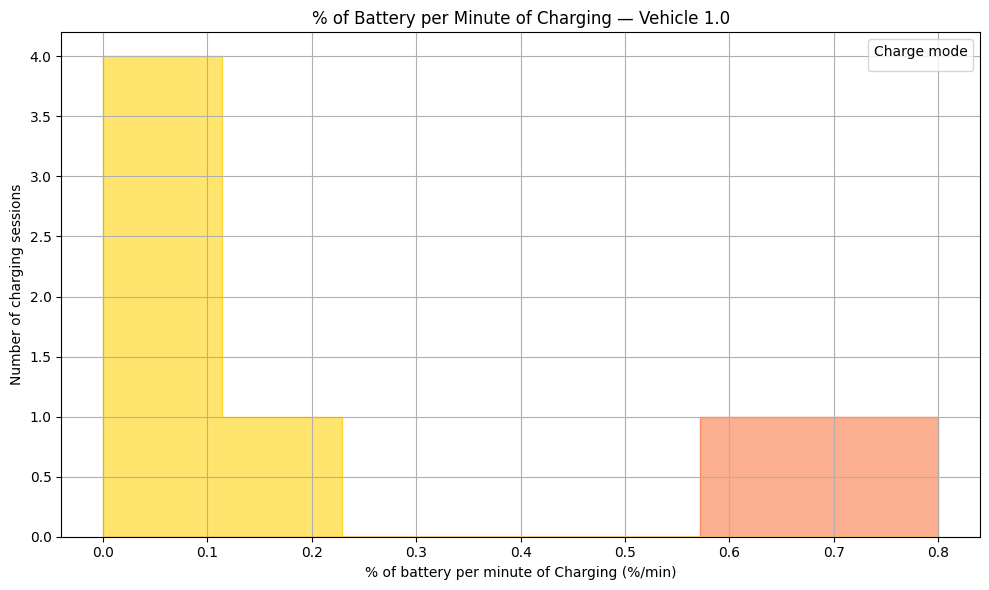

/var/folders/yf/3whxpy_91xb0fnz553qstm580000gn/T/ipykernel_34624/2634928270.py:30: UserWarning:

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.



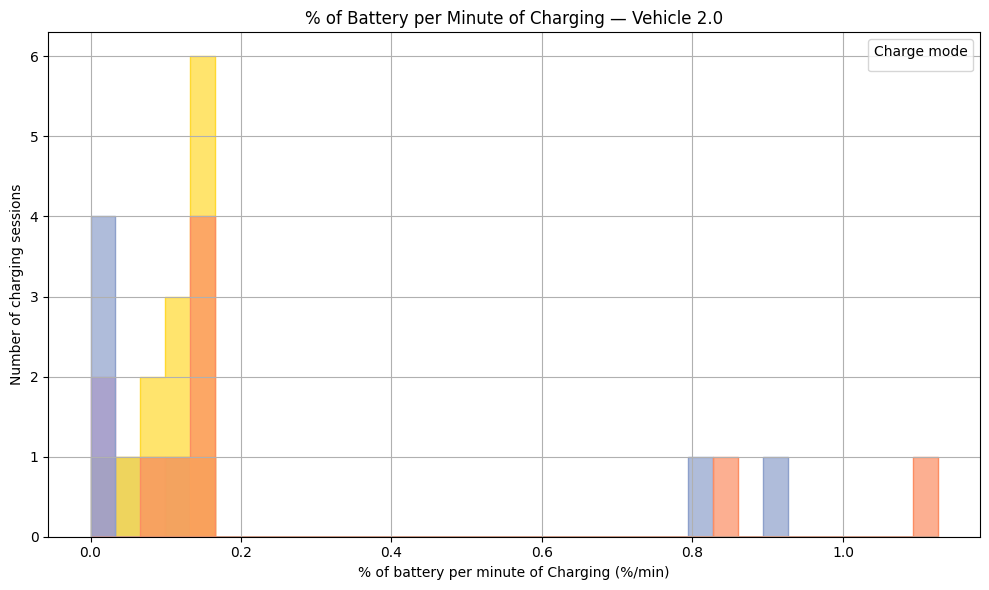

In [261]:
charge_data['perc_per_min'] = charge_data.apply(
    lambda row: row['diff_battery'] / row['duration'] if row['duration'] > 0 else 0,
    axis=1
)

vehicles = charge_data['vin'].dropna().unique()

for vin in vehicles:
    subset = charge_data[charge_data['vin'] == vin]

    if subset.empty:
        continue

    plt.figure(figsize=(10, 6))
    sns.histplot(
        data=subset,
        x='perc_per_min',
        bins=len(subset),
        hue='charge_mode',
        palette='Set2',
        element='step',
        stat='count',
        alpha=0.7
    )

    plt.title(f'% of Battery per Minute of Charging — Vehicle {vin}')
    plt.xlabel('% of battery per minute of Charging (%/min)')
    plt.ylabel('Number of charging sessions')
    plt.grid(True)
    plt.legend(title='Charge mode')
    plt.tight_layout()
    plt.show()

In [262]:
modes = charge_data['charge_mode'].dropna().unique()
colors = ['Viridis', 'Plasma', 'Cividis', 'Inferno', 'Magma', 'Turbo']

fig = go.Figure()


x = charge_data['duration'].dropna().values
y = charge_data['diff_battery'].dropna().values
xgrid = np.linspace(x.min(), x.max(), 100)
ygrid = np.linspace(y.min(), y.max(), 100)
X, Y = np.meshgrid(xgrid, ygrid)
positions = np.vstack([X.ravel(), Y.ravel()])

for i, mode in enumerate(modes):
    subset = charge_data[charge_data['charge_mode'] == mode]
    xy_subset = np.vstack([subset['duration'].values, subset['diff_battery'].values])
    
    if xy_subset.shape[1] < 2:
        continue
    
    kde = gaussian_kde(xy_subset)
    Z = np.reshape(kde(positions).T, X.shape)
    
    fig.add_trace(go.Surface(
        x=X,
        y=Y,
        z=Z,
        colorscale=colors[i % len(colors)],
        name=f'Charge mode {mode}',
        showscale=False,
        opacity=0.8,
        showlegend=True  
    ))

fig.update_layout(
    title='3D KDE Surface of Duration and Battery Difference by Charge Mode',
    scene=dict(
        xaxis_title='Duration (minutes)',
        yaxis_title='Battery difference (SoC%)',
        zaxis_title='Density'
    ),
    legend=dict(
        title="Charge Mode",
        itemsizing='constant',
        bgcolor='rgba(255,255,255,0.8)',
        bordercolor='black',
        borderwidth=1,
        x=0.8,
        y=0.9
    ),
    margin=dict(l=0, r=0, b=0, t=40)
)

fig.show()

LinAlgError: The data appears to lie in a lower-dimensional subspace of the space in which it is expressed. This has resulted in a singular data covariance matrix, which cannot be treated using the algorithms implemented in `gaussian_kde`. Consider performing principal component analysis / dimensionality reduction and using `gaussian_kde` with the transformed data.

/Users/gabriele/Desktop/Magistrale/Tesi/env/lib/python3.13/site-packages/mpl_toolkits/mplot3d/art3d.py:1403: RuntimeWarning:

divide by zero encountered in matmul

/Users/gabriele/Desktop/Magistrale/Tesi/env/lib/python3.13/site-packages/mpl_toolkits/mplot3d/art3d.py:1403: RuntimeWarning:

overflow encountered in matmul



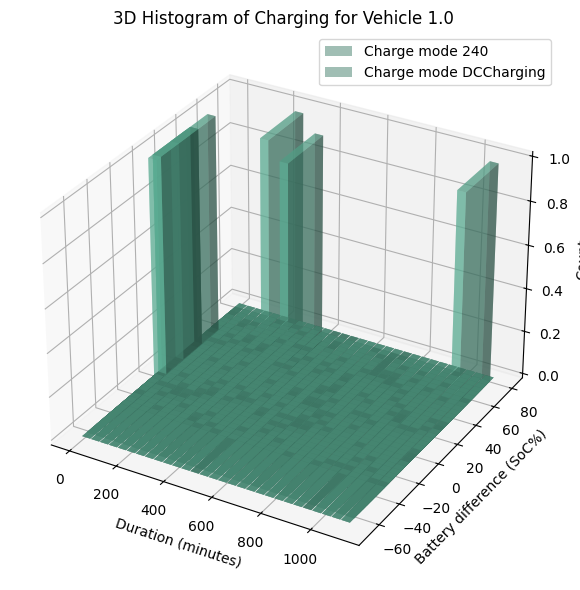

/var/folders/yf/3whxpy_91xb0fnz553qstm580000gn/T/ipykernel_34624/2864780045.py:50: UserWarning:

Creating legend with loc="best" can be slow with large amounts of data.



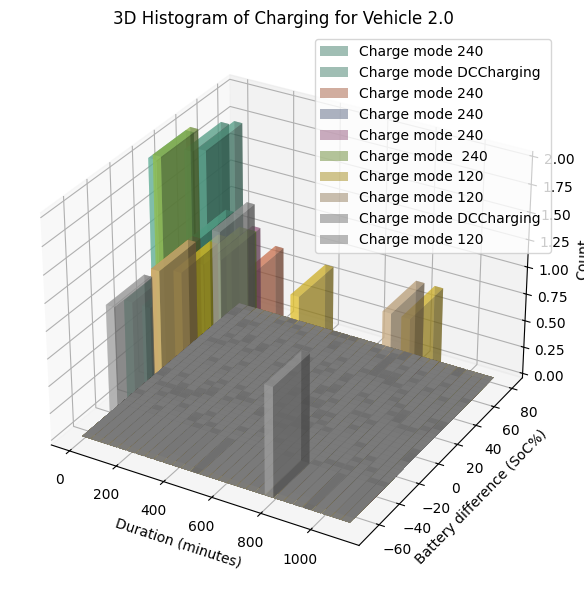

In [ ]:


vehicles = charge_data['vin'].dropna().unique()
charge_modes = charge_data['charge_mode'].dropna().unique()
colors = plt.get_cmap('Set2', len(charge_modes))  

x = charge_data['duration'].dropna()
y = charge_data['diff_battery'].dropna()
xedges = np.linspace(x.min(), x.max(), 30)
yedges = np.linspace(y.min(), y.max(), 30)
dx = dy = (xedges[1] - xedges[0]) * 0.9

for vin in vehicles:
    fig = plt.figure(figsize=(10, 6))
    ax = fig.add_subplot(111, projection='3d')

    for i, mode in enumerate(charge_modes):
        subset = charge_data[
            (charge_data['vin'] == vin) &
            (charge_data['charge_mode'] == mode)
        ]
        if subset.empty:
            continue

        hist, _, _ = np.histogram2d(
            subset['duration'].dropna(),
            subset['diff_battery'].dropna(),
            bins=[xedges, yedges],
            density=False
        )

        xpos, ypos = np.meshgrid(xedges[:-1], yedges[:-1], indexing="ij")
        xpos = xpos.ravel()
        ypos = ypos.ravel()
        zpos = np.zeros_like(xpos)
        dz = hist.ravel()

        ax.bar3d(
            xpos, ypos, zpos,
            dx, dy, dz,
            color=colors(i),
            alpha=0.5,  # più trasparente
            label=f'Charge mode {mode}',
            shade=True
        )

    ax.set_xlabel('Duration (minutes)')
    ax.set_ylabel('Battery difference (SoC%)')
    ax.set_zlabel('Count')
    ax.set_title(f'3D Histogram of Charging for Vehicle {vin}')
    ax.legend()
    plt.tight_layout()
    plt.show()

# Event timeline

In [ ]:
data['event_id'] = range(1, len(data) + 1)
first_data = data['timestamp'].min() 
last_data = data['end_time'].max()

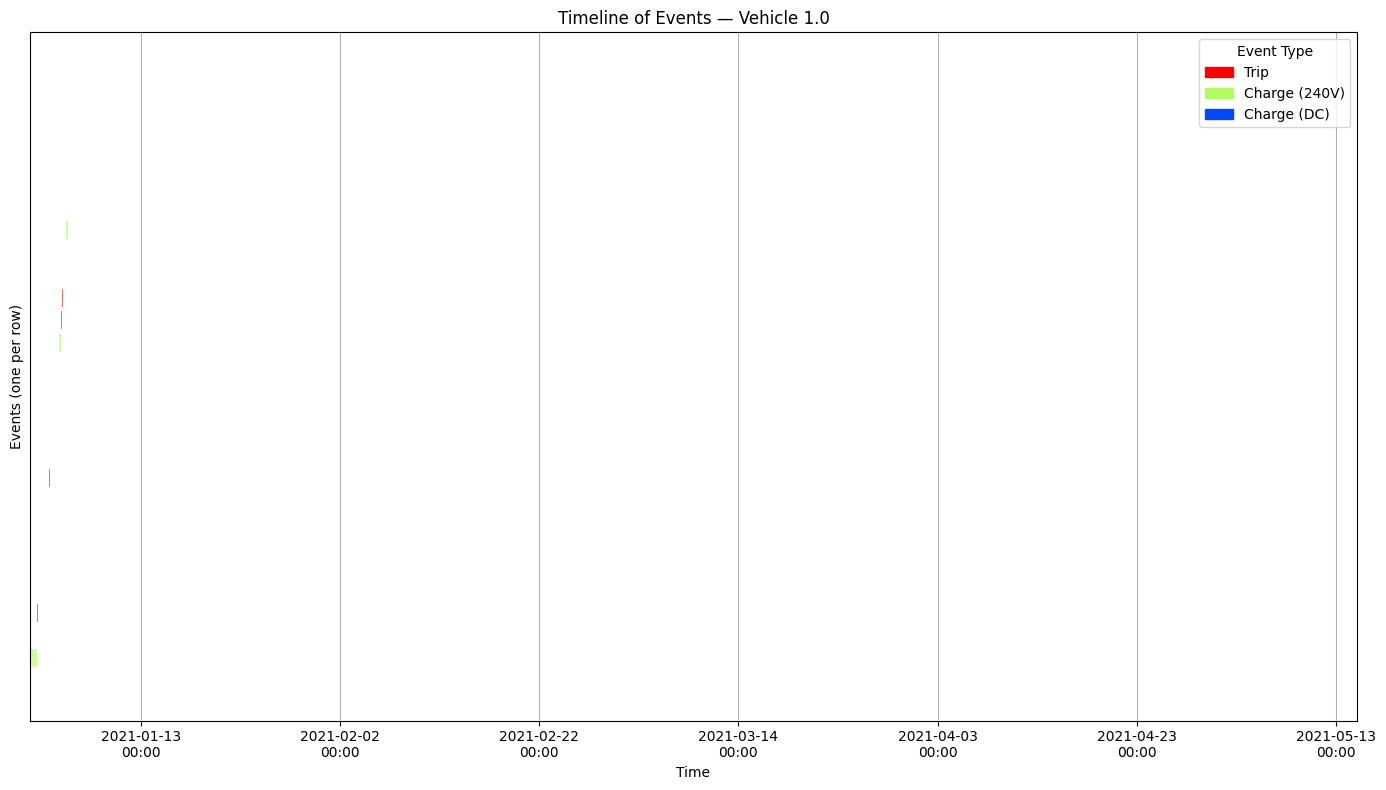

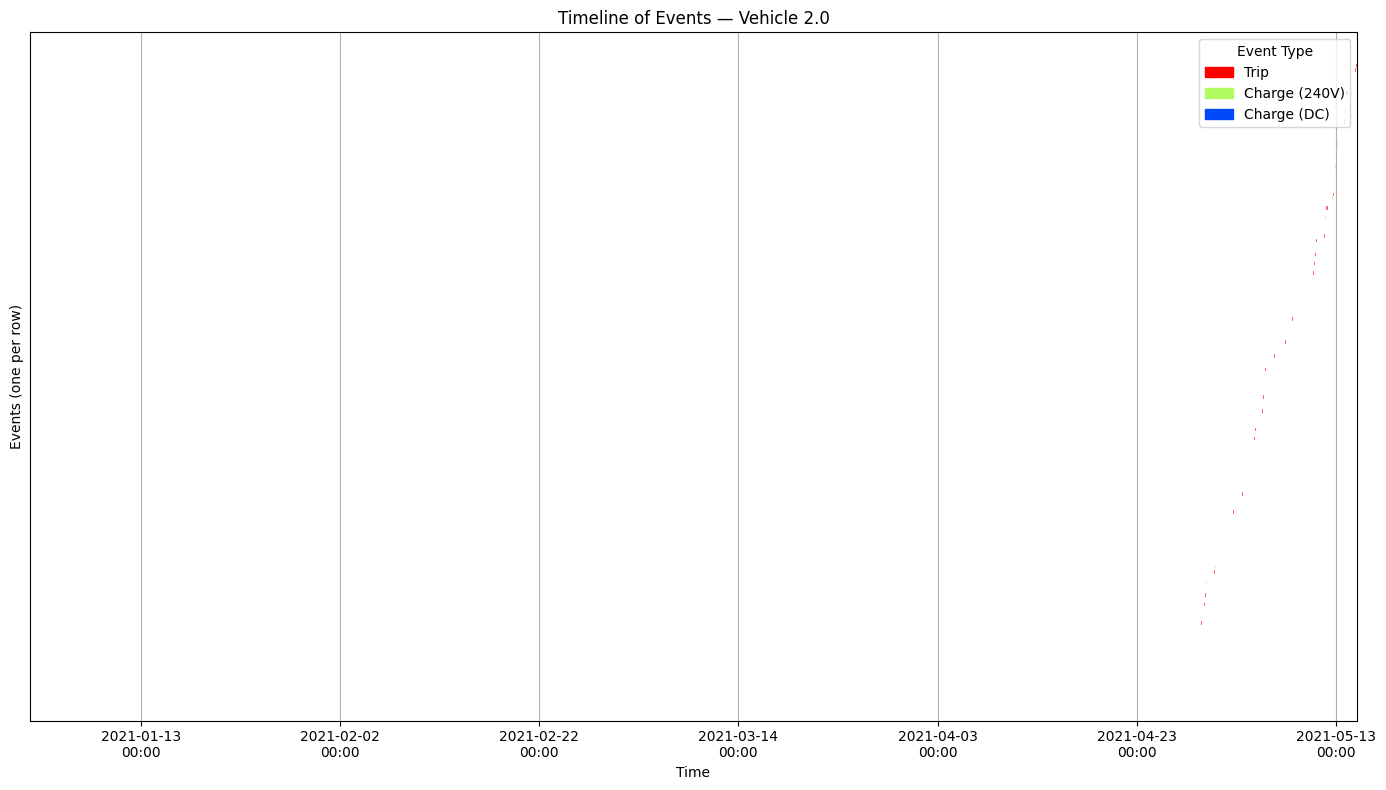

In [ ]:
def event_label(row):
    if row['event'] == 'trip':
        return 'trip'
    elif row['event'] == 'charge' and str(row['charge_mode']) == '240':
        return 'charge_240'
    elif row['event'] == 'charge' and str(row['charge_mode']) == 'DCCharging':
        return 'charge_DC'
    else:
        return 'ignore'

# Colori assegnati a ogni tipo esteso (solo i tre che ci interessano)
color_map = {
    'trip': "#ff0000",
    'charge_240': "#b2fc62",
    'charge_DC': "#004af7"
}

# Lista veicoli
vehicles = data['vin'].dropna().unique()

for vin in vehicles:
    fig, ax = plt.subplots(figsize=(14, 8))
    subset = data[data['vin'] == vin].sort_values(by='timestamp').reset_index(drop=True)

    y_offset = 0
    bar_height = 8

    for _, row in subset.iterrows():
        event_type = event_label(row)
        if event_type == 'ignore':
            continue  # salta eventi non validi

        start = mdates.date2num(row['timestamp'])
        end = mdates.date2num(row['end_time'])
        duration = end - start
        color = color_map.get(event_type, 'gray')

        ax.broken_barh(
            [(start, duration)],
            (y_offset, bar_height),
            facecolors=color,
            alpha=0.6
        )
        y_offset += bar_height + 2

    # Asse X temporale
    ax.set_xlim(mdates.date2num(first_data), mdates.date2num(last_data))
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d\n%H:%M'))
    ax.set_xlabel('Time')
    ax.set_ylabel('Events (one per row)')
    ax.set_title(f'Timeline of Events — Vehicle {vin}')
    ax.grid(True)
    ax.set_yticks([])

    # Legenda
    legend_labels = {
        'trip': 'Trip',
        'charge_240': 'Charge (240V)',
        'charge_DC': 'Charge (DC)'
    }
    legend_patches = [mpatches.Patch(color=color_map[k], label=v) for k, v in legend_labels.items()]
    ax.legend(handles=legend_patches, title='Event Type', loc='upper right')

    plt.tight_layout()
    plt.show()

In [ ]:
import plotly.graph_objects as go
import pandas as pd

# Assicura timestamp e end_time come datetime
data['timestamp'] = pd.to_datetime(data['timestamp'])
data['end_time'] = pd.to_datetime(data['end_time'])
data['event_id'] = range(1, len(data) + 1)

# Funzione per classificare l'evento
def event_label(row):
    if row['event'] == 'trip':
        return 'trip'
    elif row['event'] == 'charge' and str(row['charge_mode']) == '240':
        return 'charge_240'
    elif row['event'] == 'charge' and str(row['charge_mode']) == 'DCCharging':
        return 'charge_DC'
    else:
        return 'ignore'

# Mappa colori (tuoi esatti)
color_map = {
    'trip': "#ff0000",
    'charge_240': "#b2fc62",
    'charge_DC': "#004af7"
}

# Etichette leggibili
legend_labels = {
    'trip': 'Trip',
    'charge_240': 'Charge (240V)',
    'charge_DC': 'Charge (DC)'
}

# Lista veicoli
vehicles = data['vin'].dropna().unique()
for vin in vehicles:
    subset = data[data['vin'] == vin].sort_values(by='timestamp').reset_index(drop=True)

    fig = go.Figure()

    for i, row in subset.iterrows():
        event_type = event_label(row)
        if event_type == 'ignore':
            continue

        # Linea orizzontale che va da timestamp a end_time su y=i
        fig.add_trace(go.Scatter(
            x=[row['timestamp'], row['end_time']],
            y=[i, i],
            mode='lines+markers',
            line=dict(color=color_map[event_type], width=10),
            marker=dict(color=color_map[event_type], size=12),
            name=legend_labels[event_type],
            hovertemplate=f"ID: {row['event_id']}<br>Type: {legend_labels[event_type]}<br>Start: {row['timestamp']}<br>End: {row['end_time']}<extra></extra>",
            showlegend=not any(t.name == legend_labels[event_type] for t in fig.data)
        ))

    fig.update_layout(
        title=f"Interactive Timeline of Events — Vehicle {vin}",
        xaxis_title="Time",
        yaxis_title="Event Index",
        yaxis=dict(autorange="reversed", tickmode='linear'),
        height=600,
        legend_title="Event Type",
        xaxis=dict(
            type='date',
            tickformatstops=[
                dict(dtickrange=[None, 1000 * 60 * 60 * 24], value="%H:%M"),
                dict(dtickrange=[1000 * 60 * 60 * 24, 1000 * 60 * 60 * 24 * 7], value="%d %b"),
                dict(dtickrange=[1000 * 60 * 60 * 24 * 7, None], value="%b %Y")
            ]
        )
    )

    fig.show()

# OneHotEncoder

In [ ]:
ohe = OneHotEncoder(handle_unknown='ignore')
# Fit the one-hot encoder on training data
ohe.fit(data[cols_to_convert])
# Create a new DataFrame with only the one-hot encoded columns
temp_data = pd.DataFrame(data=ohe.transform(data[cols_to_convert]).toarray(),
                             columns=ohe.get_feature_names_out())
# Create a copy of the DataFrame
data_encoded = data.copy()

# Remove the old categorical columns from the original data
data_encoded.drop(columns=cols_to_convert, axis=1, inplace=True)
data_encoded = pd.concat([data_encoded.reset_index(drop=True), temp_data], axis=1)


In [ ]:
data_encoded.head()
#remove the column charge_mode_nan
data_encoded.drop(columns=['charge_mode_0'], axis=1, inplace=True)
data_encoded.head()

,vin,timestamp,end_time,odo,end_odo,soc,end_soc,duration,event_id,event_charge,...,charge_mode_ 240,charge_mode_120,charge_mode_120,charge_mode_120,charge_mode_240,charge_mode_240,charge_mode_240,charge_mode_240,charge_mode_DCCharging,charge_mode_DCCharging
0,1.0,2021-01-01 20:31:00,2021-01-01 20:38:00,4436.640625,4439.46875,56.4,54.9,7.0,1,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,1.0,2021-01-01 20:39:00,2021-01-02 15:13:00,4439.468750,4439.46875,54.9,100.0,1114.0,2,1.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
2,1.0,2021-01-02 15:13:00,2021-01-02 15:21:00,4439.468750,4442.50000,100.0,100.0,8.0,3,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,1.0,2021-01-02 15:21:00,2021-01-02 17:46:00,4442.500000,4457.12500,100.0,94.5,145.0,4,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,1.0,2021-01-02 17:46:00,2021-01-02 17:53:00,4457.125000,4461.45000,94.5,94.5,7.0,5,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [ ]:
#selecting numerical columns
cols_to_exclude = ['vin', 'event_id']
numerical_cols = data_encoded.select_dtypes(include=['int64', 'float64']).columns.tolist()
numerical_cols = [col for col in numerical_cols if col not in cols_to_exclude]


# Selecting only numerical columns for correlation
numerical_data = data_encoded[numerical_cols]
vehicles = data_encoded['vin'].unique()


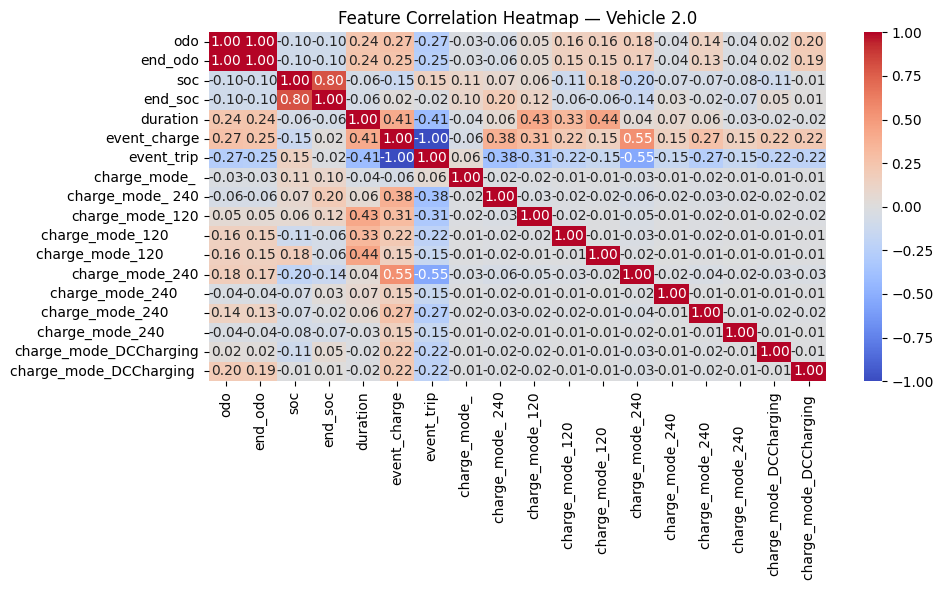

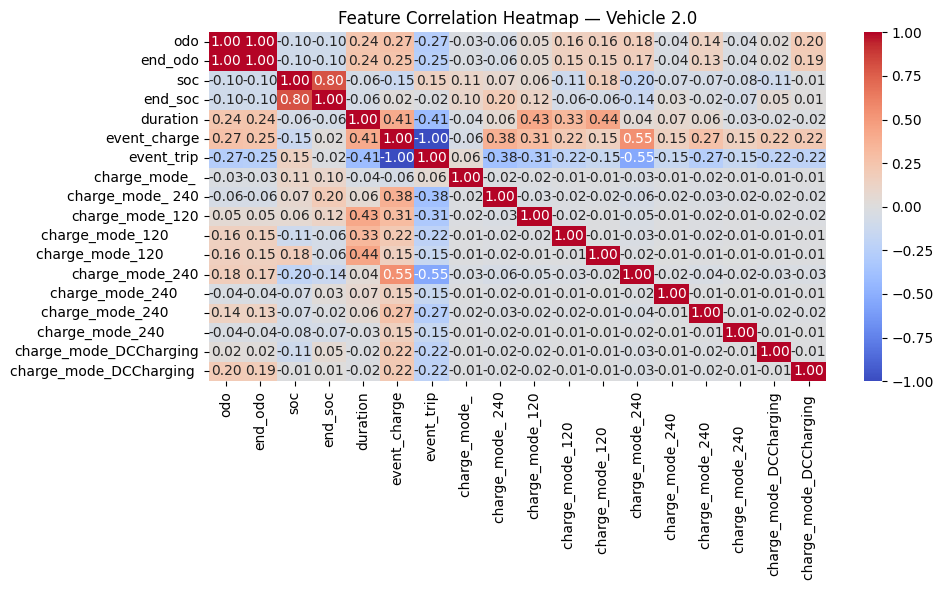

In [ ]:
for vehicle in vehicles:
    subset = data_encoded[data_encoded['vin'] == vin]

    numerical_data = subset[numerical_cols]

    if numerical_data.shape[0] < 2:
        continue 

    corr = numerical_data.corr()

    plt.figure(figsize=(10, 6))
    sns.heatmap(corr, annot=True, cmap="coolwarm", fmt=".2f", vmin=-1, vmax=1)
    plt.title(f'Feature Correlation Heatmap — Vehicle {vin}')
    plt.tight_layout()
    plt.show()

In [ ]:
data_encoded.to_csv('./Dataset_dumarey/preprocessed_dataset/dataset_rounded_OHE.csv', index=False)

# 2D Embedding

In [ ]:
data_embedded = data.copy()

In [ ]:
data_embedded.info()


<class 'pandas.core.frame.DataFrame'>
Index: 184 entries, 0 to 191
Data columns (total 11 columns):
 #   Column       Non-Null Count  Dtype         
---  ------       --------------  -----         
 0   vin          184 non-null    float64       
 1   timestamp    184 non-null    datetime64[ns]
 2   end_time     184 non-null    datetime64[ns]
 3   odo          184 non-null    float64       
 4   end_odo      184 non-null    float64       
 5   soc          184 non-null    float64       
 6   end_soc      184 non-null    float64       
 7   event        184 non-null    category      
 8   charge_mode  184 non-null    category      
 9   duration     184 non-null    float64       
 10  event_id     184 non-null    int64         
dtypes: category(2), datetime64[ns](2), float64(6), int64(1)
memory usage: 15.2 KB


In [ ]:
data_embedded.head()

,vin,timestamp,end_time,odo,end_odo,soc,end_soc,event,charge_mode,duration,event_id
0,1.0,2021-01-01 20:31:00,2021-01-01 20:38:00,4436.640625,4439.46875,56.4,54.9,trip,0,7.0,1
1,1.0,2021-01-01 20:39:00,2021-01-02 15:13:00,4439.468750,4439.46875,54.9,100.0,charge,240,1114.0,2
2,1.0,2021-01-02 15:13:00,2021-01-02 15:21:00,4439.468750,4442.50000,100.0,100.0,trip,0,8.0,3
3,1.0,2021-01-02 15:21:00,2021-01-02 17:46:00,4442.500000,4457.12500,100.0,94.5,trip,0,145.0,4
4,1.0,2021-01-02 17:46:00,2021-01-02 17:53:00,4457.125000,4461.45000,94.5,94.5,trip,0,7.0,5


In [ ]:
# === EMBEDDING PREPARATION ===
import torch
label_encoders = {}
cat_indices = {}
for col in cols_to_convert:
    le = LabelEncoder()
    cat_indices[col + "_idx"] = le.fit_transform(data_embedded[col].astype(str))
    label_encoders[col] = le

data_cat_idx = pd.DataFrame(cat_indices)
X_cat = torch.tensor(data_cat_idx.values, dtype=torch.long)

num_classes_per_cat = [len(label_encoders[col].classes_) for col in cols_to_convert]
embedding_dims = [2 for _ in num_classes_per_cat]  # oppure scegli dinamicamente

embedding_layers = nn.ModuleList([
    nn.Embedding(num_embeddings=n, embedding_dim=d)
    for n, d in zip(num_classes_per_cat, embedding_dims)
])

# 4. Applica gli embedding
embedded_parts = [embedding_layers[i](X_cat[:, i]) for i in range(X_cat.shape[1])]
embedded_features = torch.cat(embedded_parts, dim=1)  # [num_samples, total_emb_dim]

# Converti gli embedding in DataFrame
embedded_feature_names = []
for col, dim in zip(cols_to_convert, embedding_dims):
    embedded_feature_names.extend([f"{col}_emb_{i}" for i in range(dim)])

df_embedded = pd.DataFrame(embedded_features.detach().numpy(), columns=embedded_feature_names)


# === UNISCI CON LE FEATURE CONTINUE ===
# (escludi le colonne categoriche originali)
data_noncat = data_embedded.drop(columns=cols_to_convert).reset_index(drop=True)

# 7. Combina finali
data_embedded = pd.concat([data_noncat, df_embedded], axis=1)

In [ ]:
data_embedded.head()

,vin,timestamp,end_time,odo,end_odo,soc,end_soc,duration,event_id,event_emb_0,event_emb_1,charge_mode_emb_0,charge_mode_emb_1
0,1.0,2021-01-01 20:31:00,2021-01-01 20:38:00,4436.640625,4439.46875,56.4,54.9,7.0,1,-1.765609,-1.559750,-0.515131,-0.108062
1,1.0,2021-01-01 20:39:00,2021-01-02 15:13:00,4439.468750,4439.46875,54.9,100.0,1114.0,2,-2.080462,0.323883,-0.462215,0.489571
2,1.0,2021-01-02 15:13:00,2021-01-02 15:21:00,4439.468750,4442.50000,100.0,100.0,8.0,3,-1.765609,-1.559750,-0.515131,-0.108062
3,1.0,2021-01-02 15:21:00,2021-01-02 17:46:00,4442.500000,4457.12500,100.0,94.5,145.0,4,-1.765609,-1.559750,-0.515131,-0.108062
4,1.0,2021-01-02 17:46:00,2021-01-02 17:53:00,4457.125000,4461.45000,94.5,94.5,7.0,5,-1.765609,-1.559750,-0.515131,-0.108062


In [ ]:
cols_to_convert = ['event_emb_0','event_emb_1', 'charge_mode_emb_0', 'charge_mode_emb_1']
data_embedded[cols_to_convert] = data_embedded[cols_to_convert].astype('float64')
data_embedded.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 184 entries, 0 to 183
Data columns (total 13 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   vin                184 non-null    float64       
 1   timestamp          184 non-null    datetime64[ns]
 2   end_time           184 non-null    datetime64[ns]
 3   odo                184 non-null    float64       
 4   end_odo            184 non-null    float64       
 5   soc                184 non-null    float64       
 6   end_soc            184 non-null    float64       
 7   duration           184 non-null    float64       
 8   event_id           184 non-null    int64         
 9   event_emb_0        184 non-null    float64       
 10  event_emb_1        184 non-null    float64       
 11  charge_mode_emb_0  184 non-null    float64       
 12  charge_mode_emb_1  184 non-null    float64       
dtypes: datetime64[ns](2), float64(10), int64(1)
memory usage: 18.8 KB

In [ ]:
data_embedded.to_csv('./Dataset_dumarey/preprocessed_dataset/dataset_rounded_2DE.csv', index=False)

### Timestamp Normalization to Hours Since Start

In [ ]:
#select the least recent date in timestamp
min_date = data_embedded['timestamp'].min()
#compute the difference in hour from the minimum date
data_embedded['timestamp'] = (data_embedded['timestamp'] - min_date).dt.total_seconds() / 3600
data_embedded['end_time'] = (data_embedded['end_time'] - min_date).dt.total_seconds() / 3600

In [ ]:
#selecting numerical columns
cols_to_exclude = ['vin', 'event_id']
numerical_cols = data_embedded.select_dtypes(include=['int64', 'float64']).columns.tolist()
numerical_cols = [col for col in numerical_cols if col not in cols_to_exclude]

# Selecting only numerical columns for correlation
numerical_data = data_embedded[numerical_cols]
vehicles = data_embedded['vin'].unique()

### Feature Correlation Heatmap

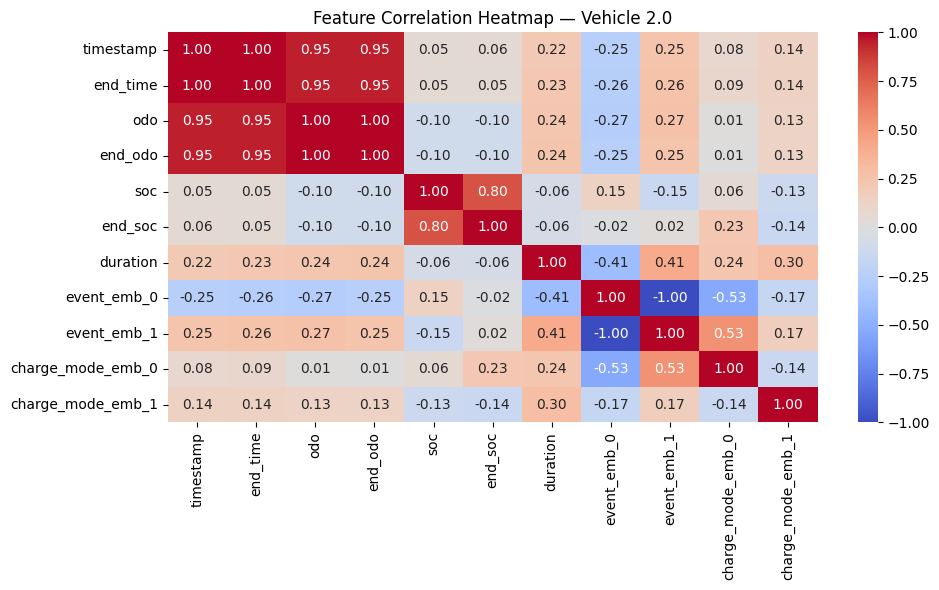

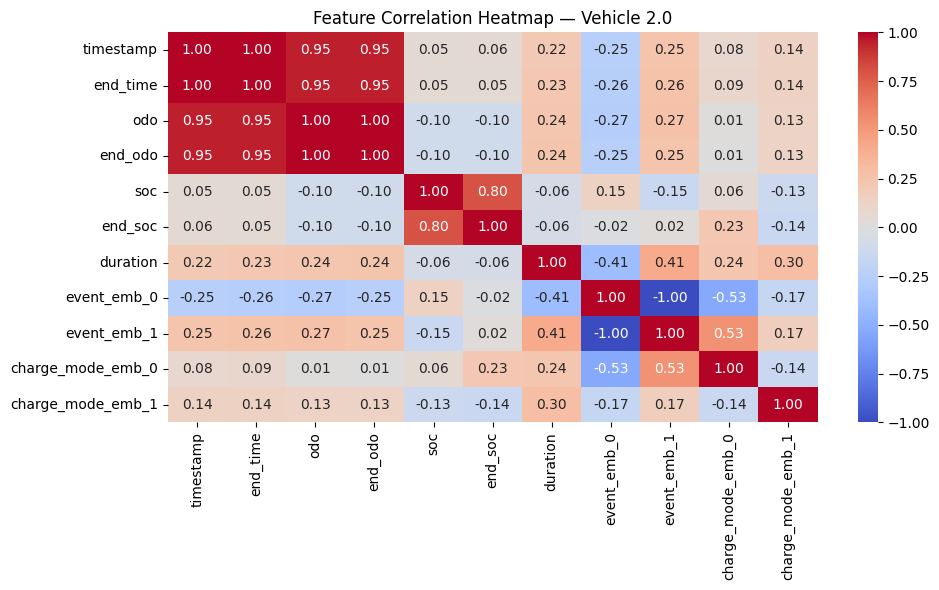

In [ ]:
for vehicle in vehicles:
    subset = data_embedded[data_encoded['vin'] == vin]

    numerical_data = subset[numerical_cols]

    if numerical_data.shape[0] < 2:
        continue 

    corr = numerical_data.corr()

    plt.figure(figsize=(10, 6))
    sns.heatmap(corr, annot=True, cmap="coolwarm", fmt=".2f", vmin=-1, vmax=1)
    plt.title(f'Feature Correlation Heatmap — Vehicle {vin}')
    plt.tight_layout()
    plt.show()


In [ ]:
data_embedded.to_csv('./Dataset_dumarey/preprocessed_dataset/dataset_rounded_2DE_time_norm.csv', index=False)

In [ ]:
# Ripristina i valori originali da data_embedded
data_embedded['event'] = label_encoders['event'].inverse_transform(data_cat_idx['event_idx'])
data_embedded['charge_mode'] = label_encoders['charge_mode'].inverse_transform(data_cat_idx['charge_mode_idx'])

# Rimuovi le colonne inutili (embedding e indici)
data_from_2DE_to_original = data_embedded.drop(columns=[
    'event_emb_0', 'event_emb_1',
    'charge_mode_emb_0', 'charge_mode_emb_1'
])

In [ ]:
data_from_2DE_to_original.head()

,vin,timestamp,end_time,odo,end_odo,soc,end_soc,duration,event_id,event,charge_mode
0,1.0,0.000000,0.116667,4436.640625,4439.46875,56.4,54.9,7.0,1,trip,0
1,1.0,0.133333,18.700000,4439.468750,4439.46875,54.9,100.0,1114.0,2,charge,240
2,1.0,18.700000,18.833333,4439.468750,4442.50000,100.0,100.0,8.0,3,trip,0
3,1.0,18.833333,21.250000,4442.500000,4457.12500,100.0,94.5,145.0,4,trip,0
4,1.0,21.250000,21.366667,4457.125000,4461.45000,94.5,94.5,7.0,5,trip,0


In [ ]:
cols_to_convert = ['event', 'charge_mode']
for col in cols_to_convert:
    data_from_2DE_to_original[col] = data_from_2DE_to_original[col].astype('category')
data_from_2DE_to_original.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 184 entries, 0 to 183
Data columns (total 11 columns):
 #   Column       Non-Null Count  Dtype   
---  ------       --------------  -----   
 0   vin          184 non-null    float64 
 1   timestamp    184 non-null    float64 
 2   end_time     184 non-null    float64 
 3   odo          184 non-null    float64 
 4   end_odo      184 non-null    float64 
 5   soc          184 non-null    float64 
 6   end_soc      184 non-null    float64 
 7   duration     184 non-null    float64 
 8   event_id     184 non-null    int64   
 9   event        184 non-null    category
 10  charge_mode  184 non-null    category
dtypes: category(2), float64(8), int64(1)
memory usage: 13.9 KB


- Trasformare gli object in float64 (Done)
- Capire come gestire le date (Done)
- Data fine evento si può convertire in durata evento? (ho inserito la data duration)
- Verificare se ci siano valori null (Done)
- Verificare se ci sono duplicati (Done)
- Fare feature correlation heatmap (Done)
- Onehot encoding (Done)
- Trasformare la colonna vm dato che si riferisce a singoli veicoli(ID) tipo in vec1 vec2 ecc
- Come gestisco i missing values?  
- come convertire gli embeddings dopo la generazione? (classificatore, nearest neighbor, from sklearn.metrics.pairwise import euclidean_distances)
